## Импортируем модули

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
import random
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, accuracy_score
import cv2
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import pickle
from joblib import dump, load

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.models import load_model

## Анализ датасета

In [43]:
def img_show(imgName, title):
    image = plt.imread(imgName)
    plt.figure(figsize=(20, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

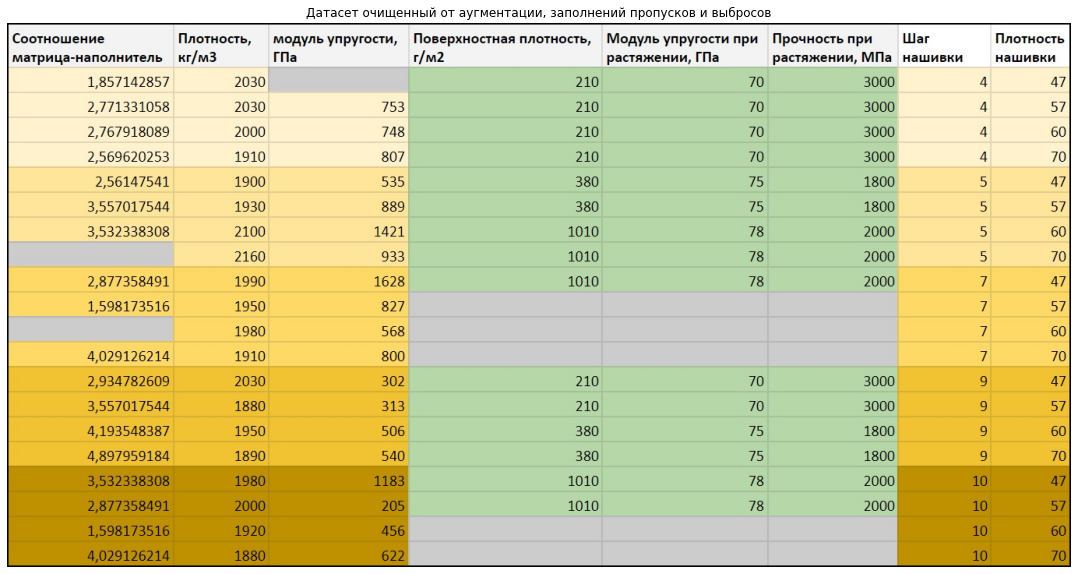

In [44]:
img_show('img\Исходный датасет.jpg', 'Датасет очищенный от аугментации, заполнений пропусков и выбросов')

Как видно из таблицы, следующие своства явно коррелируют между собой:
- Модуль упругости при растяжении, ГПа
- Поверхностная плотность, г/м2
- Прочность при растяжении, МПа

Датасет состоит из 20 записей, которые предположительно можно разделить можно разделить на 2 блока по 10. 
Если наложить эти 2 блока друг на друга, будет видно, что они совпадают. 
На основании этого можно этими данными и заполнить пропуски, а недостающие данные просто продлить логически.

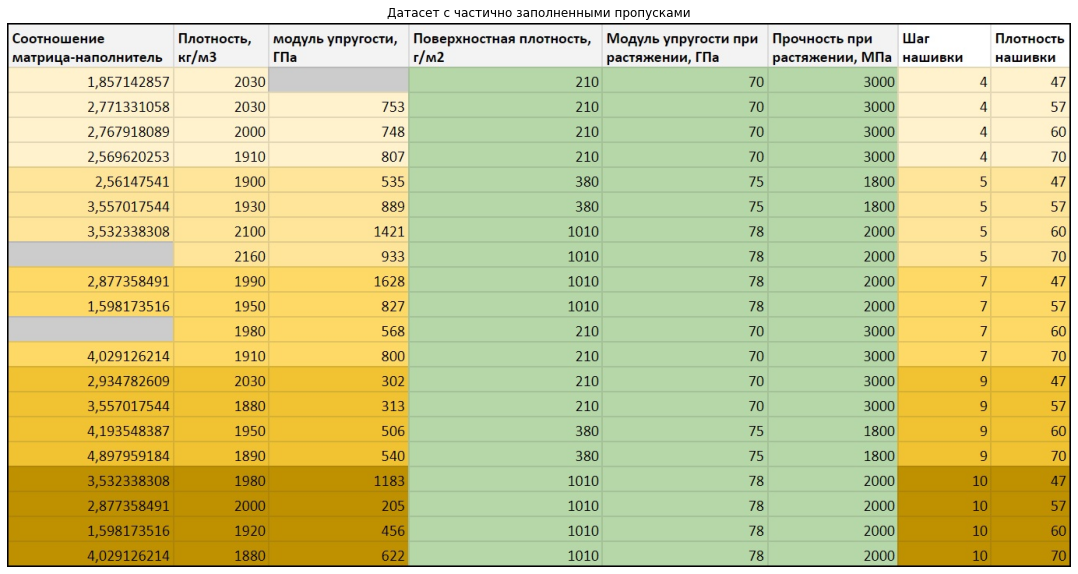

In [45]:
img_show('img\Датасет с частично заполненными пропусками.jpg', 
         'Датасет с частично заполненными пропусками')

Результат заполнения пропусков на изображении.

Из текущих свойств можно сформировать новое, толщину.                 
По формуле: "Поверхностная плотность, г/м2" / "Плотность, кг/м3" = Толщина, мм

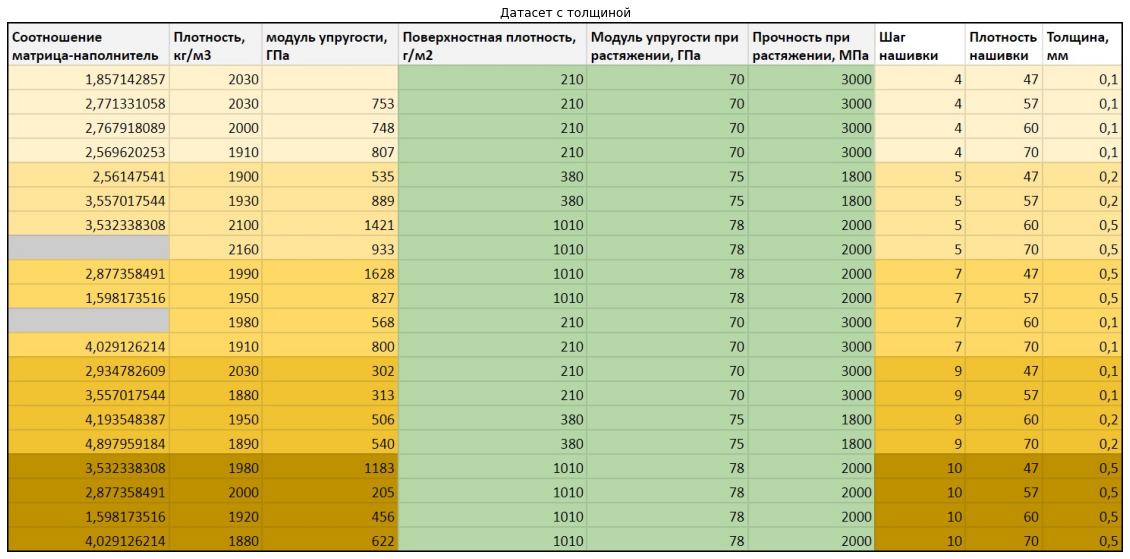

In [48]:
img_show('img\Датасет с толщиной.jpg', 'Датасет с толщиной')

Если округлить до 1 знака после запятой, то получается использовался базальтопластик толщиной 0.1, 0.2, 0.5 мм

### Загрузим подготовленный датасет

In [2]:
## Итоговый датасет подготовлен в Excel
df = pd.read_excel('Датасет.xlsx')
df.head(20)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
0,1.857143,2030.0,NaN,210.0,70.0,3000.0,4.0,47.0,0.1
1,2.771331,2030.0,753.0,210.0,70.0,3000.0,4.0,57.0,0.1
2,2.767918,2000.0,748.0,210.0,70.0,3000.0,4.0,60.0,0.1
3,2.569620,1910.0,807.0,210.0,70.0,3000.0,4.0,70.0,0.1
4,2.561475,1900.0,535.0,380.0,75.0,1800.0,5.0,47.0,0.2
5,3.557018,1930.0,889.0,380.0,75.0,1800.0,5.0,57.0,0.2
6,3.532338,2100.0,1421.0,1010.0,78.0,2000.0,5.0,60.0,0.5
7,NaN,2160.0,933.0,1010.0,78.0,2000.0,5.0,70.0,0.5
8,2.877358,1990.0,1628.0,1010.0,78.0,2000.0,7.0,47.0,0.5
9,1.598174,1950.0,827.0,1010.0,78.0,2000.0,7.0,57.0,0.5


In [6]:
def MyAugmentation(data, targetColumn):
    X_hard = data.copy()
    for column in X_hard.columns:
        if column == targetColumn:
            continue
        X_append = data.copy()
        for i in X_append[column].index:
            X_append[column][i] = random.random()
        X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)
    return X_hard

In [7]:
def select_best_value(data, targetColumn, indexRow, history, roundValue = 0, countBreak = 100, countIters = 1):
    
    #Считываем стартовое значение
    value = data[targetColumn][indexRow:indexRow+1][indexRow] 
    
    #Делаем аугментацию
    X_aug = MyAugmentation(data, targetColumn)
    
    #Отделяем целевую переменную
    X = X_aug.drop(columns=[targetColumn])
    y = X_aug[targetColumn]

    # Разбиваем на тренировочную и тестовую выборки
    quantity_column = df_train.shape[0]
    X_train = X.iloc[quantity_column:]
    y_train = y.iloc[quantity_column:]
    X_test = X.iloc[:quantity_column]
    y_test = y.iloc[:quantity_column]
    
    #Обучаем модель
    regr = RandomForestRegressor(max_depth=7, random_state=0)
    regr.fit(X_train, y_train)
    
    #Прогнозируем значение и записываем в историю
    y_pred = round(regr.predict(data.drop(columns=targetColumn)[indexRow:indexRow+1])[0], roundValue)
    history.append(y_pred)
    
    #Если округление до целых, преобразовываем в Int
    if roundValue == 0:
        y_pred = int(y_pred)
        
    #Повторяем операцию пока значение не перестанет менятся, либо пока не будет достигнут установленный лимит попыток
    if y_pred != value and countBreak != countIters:
        countIters += 1
        select_best_value(data, targetColumn, indexRow, history, roundValue, countBreak, countIters)

In [35]:
#Установим среднее значение по 3м значениям идущим после, равным 769, очистим остальные строки с NaN
df['модуль упругости, ГПа'][0:1] = 769
df_MU = df.dropna()
df_MU.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
0,1.857143,2030.0,769.0,210.0,70.0,3000.0,4.0,47.0,0.1
1,2.771331,2030.0,753.0,210.0,70.0,3000.0,4.0,57.0,0.1
2,2.767918,2000.0,748.0,210.0,70.0,3000.0,4.0,60.0,0.1


In [36]:
history = []
select_best_value(df_MU, 'модуль упругости, ГПа', 0, history, 0, 200)

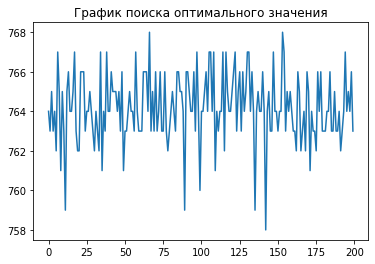

In [39]:
plt.title('График поиска оптимального значения')
plt.plot(history)

(array([ 1.,  3.,  1.,  5., 12., 45., 56., 29., 29., 19.]),
 array([758., 759., 760., 761., 762., 763., 764., 765., 766., 767., 768.]),
 <BarContainer object of 10 artists>)

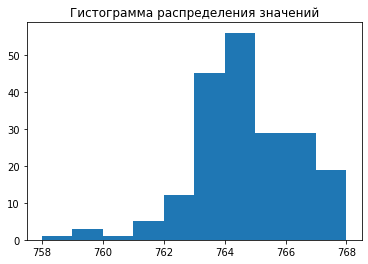

In [40]:
plt.title('Гистограмма распределения значений')
plt.hist(history)

Эксперимент проводился несколько раз, на разном количестве циклов, по итогу больше всего получается попалось значение: 764, его и установим.

In [3]:
df['модуль упругости, ГПа'][0:1] = 764

In [4]:
df_MU = df.dropna()
df_MU.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
0,1.857143,2030.0,764.0,210.0,70.0,3000.0,4.0,47.0,0.1
1,2.771331,2030.0,753.0,210.0,70.0,3000.0,4.0,57.0,0.1
2,2.767918,2000.0,748.0,210.0,70.0,3000.0,4.0,60.0,0.1


Усомнимся в правильности выбора значения, и попробуем несколько раз прогнать через метод поиска значения.

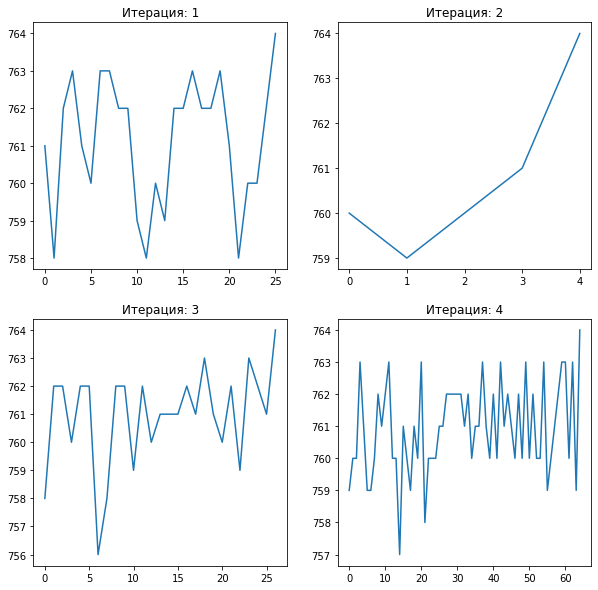

In [71]:
plt.figure(figsize=(10, 10))
for i in range(1, 5):
    history = []
    select_best_value(df_MU, 'модуль упругости, ГПа', 0, history, 0, 200)
    plt.subplot(2, 2, i)
    plt.title('Итерация: ' + str(i))
    plt.plot(history)
plt.show()

Во всех случаях останавливается на значении 764. Предполагаем, что выбор верный и оставляем значение.

In [5]:
df_new = df_MU

### Построим тепловую карту

<AxesSubplot:>

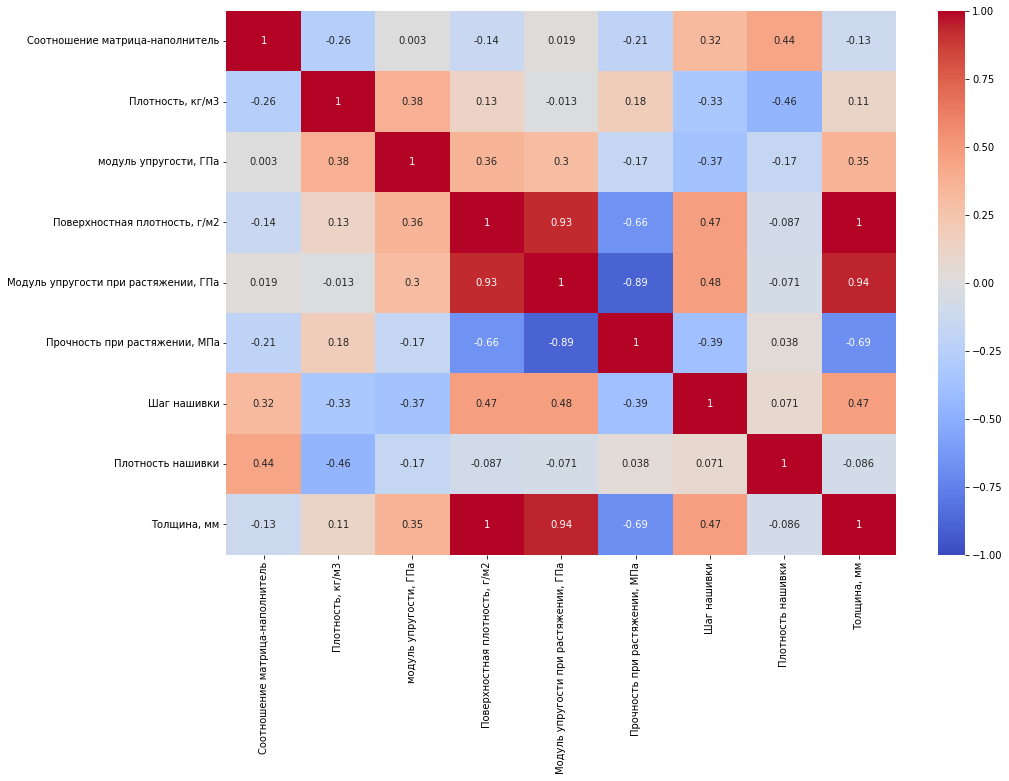

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(df_new.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

Из тепловой карты можно сделать вывод, следующие пары свойств имеют зависимости: 
- "Прочность при растяжении, МПа" и "Модуль упругости при растяжении, ГПа" зависимы 
- "Прочность при растяжении, МПа" и "Поверхностная плотность, г/м2"
- "Модуль упругости при растяжении, ГПа" и "Поверхностная плотность, г/м2"

### Построим попарные графики

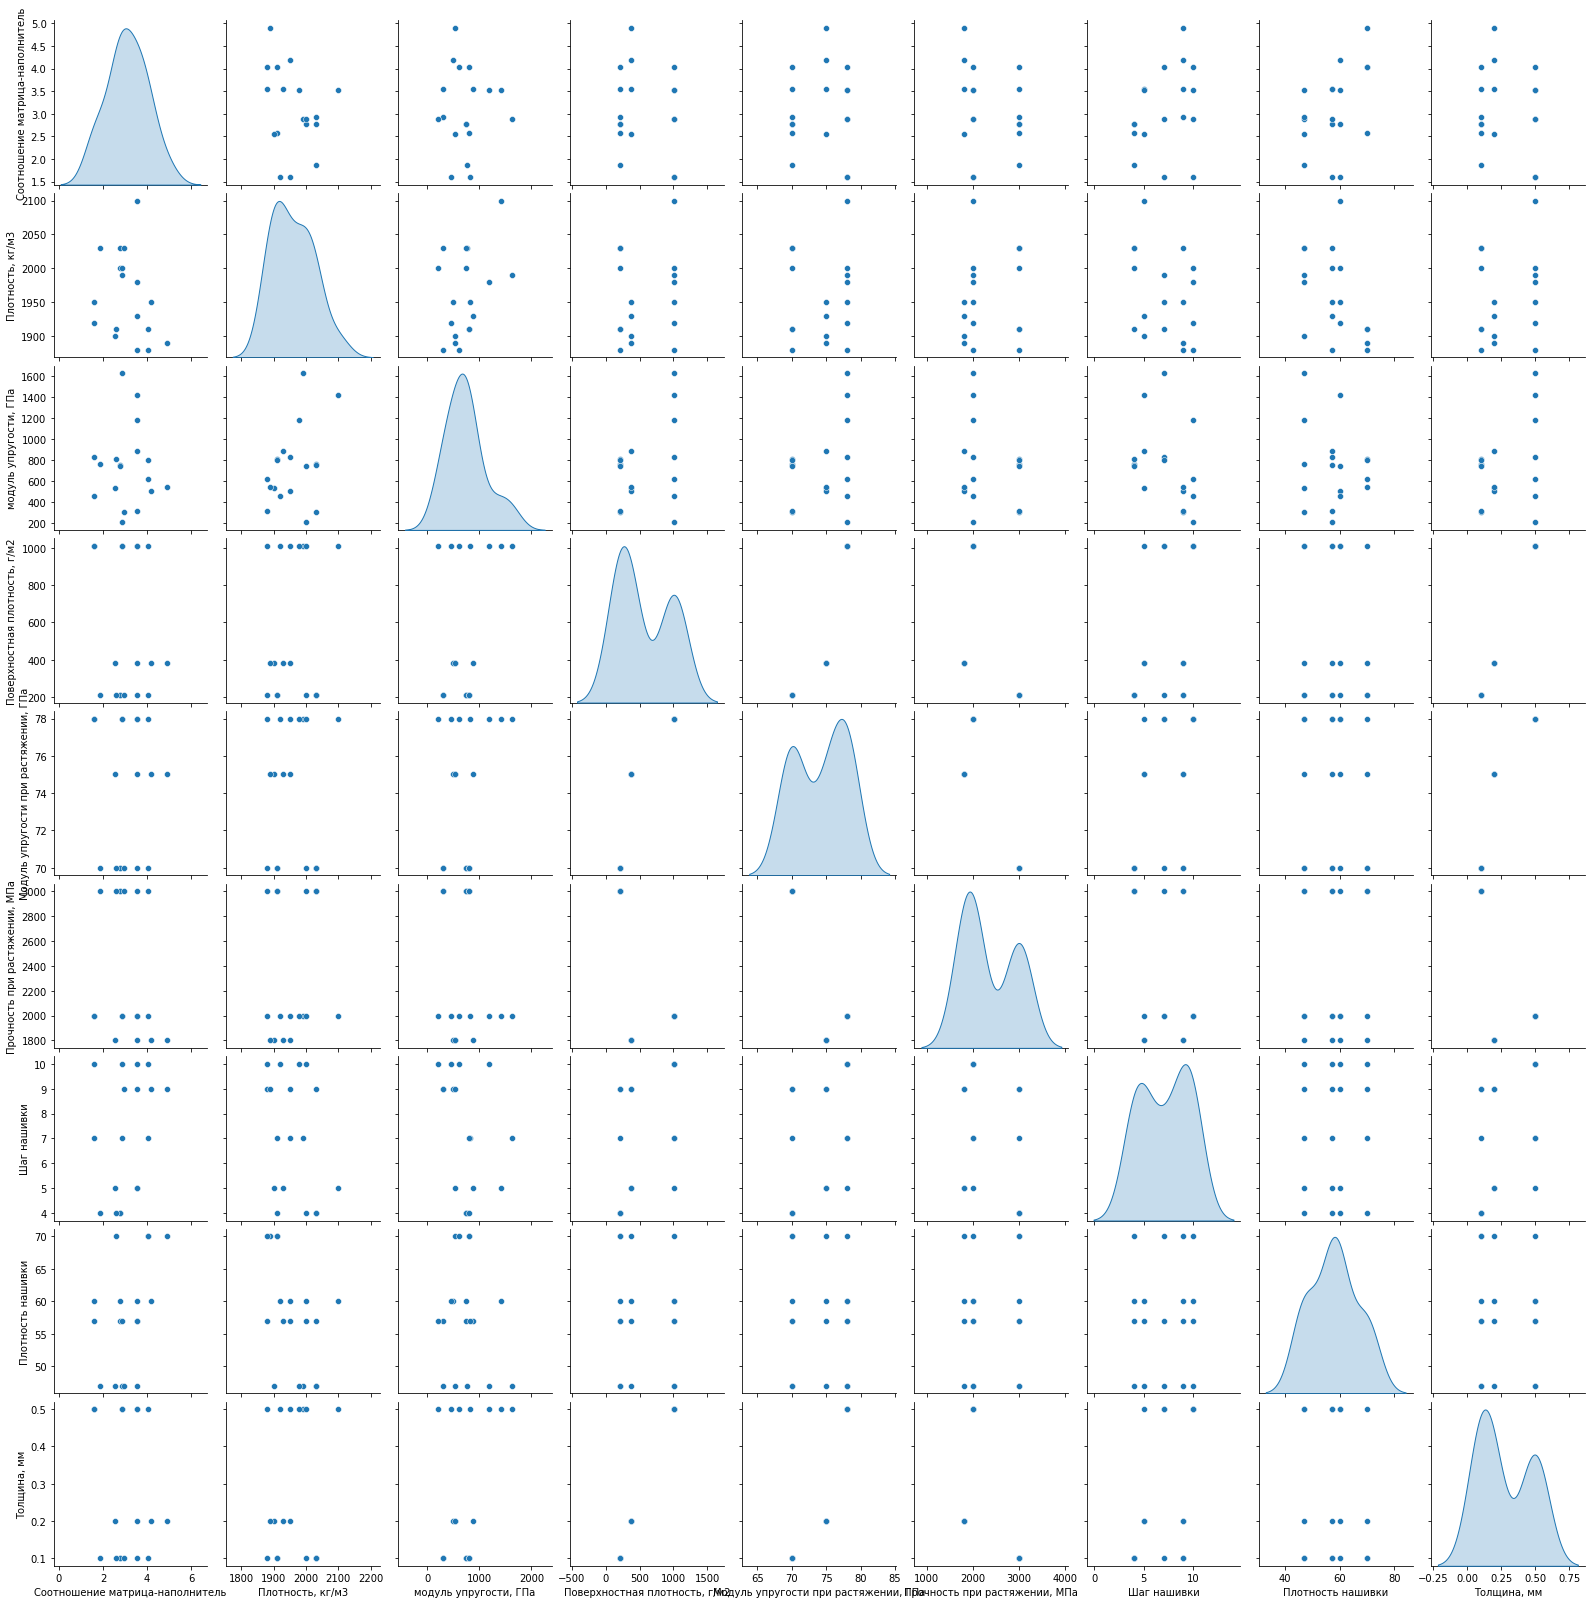

In [77]:
sns.pairplot(df_new, diag_kind='kde')
plt.show()

Из парных графиков можно сделать предположение, что зависимость нелинейная

### Описательная статистика

In [6]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,18.0,3.096767,0.904828,1.598174,2.619195,2.906071,3.557018,4.897959
"Плотность, кг/м3",18.0,1960.000000,63.152477,1880.000000,1910.000000,1950.000000,2000.000000,2100.000000
"модуль упругости, ГПа",18.0,738.833333,374.083704,205.000000,513.250000,750.500000,822.000000,1628.000000
"Поверхностная плотность, г/м2",18.0,558.888889,376.092743,210.000000,210.000000,380.000000,1010.000000,1010.000000
"Модуль упругости при растяжении, ГПа",18.0,74.222222,3.655062,70.000000,70.000000,75.000000,78.000000,78.000000
"Прочность при растяжении, МПа",18.0,2344.444444,543.650214,1800.000000,2000.000000,2000.000000,3000.000000,3000.000000
Шаг нашивки,18.0,7.111111,2.422660,4.000000,5.000000,7.000000,9.000000,10.000000
Плотность нашивки,18.0,57.777778,8.405569,47.000000,49.500000,57.000000,60.000000,70.000000
"Толщина, мм",18.0,0.277778,0.186470,0.100000,0.100000,0.200000,0.500000,0.500000


### Стандартизируем данные и построим все бары на одном графике

In [7]:
s_scaler = preprocessing.StandardScaler()
df_stn = pd.DataFrame(s_scaler.fit_transform(df_new), columns=df_new.columns)
df_stn

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
0,-1.409729,1.140563,0.069226,-0.954562,-1.188661,1.240800,-1.321402,-1.319392,-0.981023
1,-0.370093,1.140563,0.038968,-0.954562,-1.188661,1.240800,-1.321402,-0.095214,-0.981023
2,-0.373975,0.651751,0.025215,-0.954562,-1.188661,1.240800,-1.321402,0.272040,-0.981023
3,-0.599483,-0.814688,0.187506,-0.954562,-1.188661,1.240800,-1.321402,1.496218,-0.981023
4,-0.608746,-0.977626,-0.560684,-0.489441,0.218964,-1.030495,-0.896665,-1.319392,-0.429198
5,0.523408,-0.488813,0.413063,-0.489441,0.218964,-1.030495,-0.896665,-0.095214,-0.429198
6,0.495342,2.281127,1.876435,1.234242,1.063539,-0.651946,-0.896665,0.272040,1.226279
7,-0.249516,0.488813,2.445829,1.234242,1.063539,-0.651946,-0.047193,-1.319392,1.226279
8,-1.704235,-0.162938,0.242520,1.234242,1.063539,-0.651946,-0.047193,-0.095214,1.226279
9,1.060300,-0.814688,0.168251,-0.954562,-1.188661,1.240800,-0.047193,1.496218,-0.981023


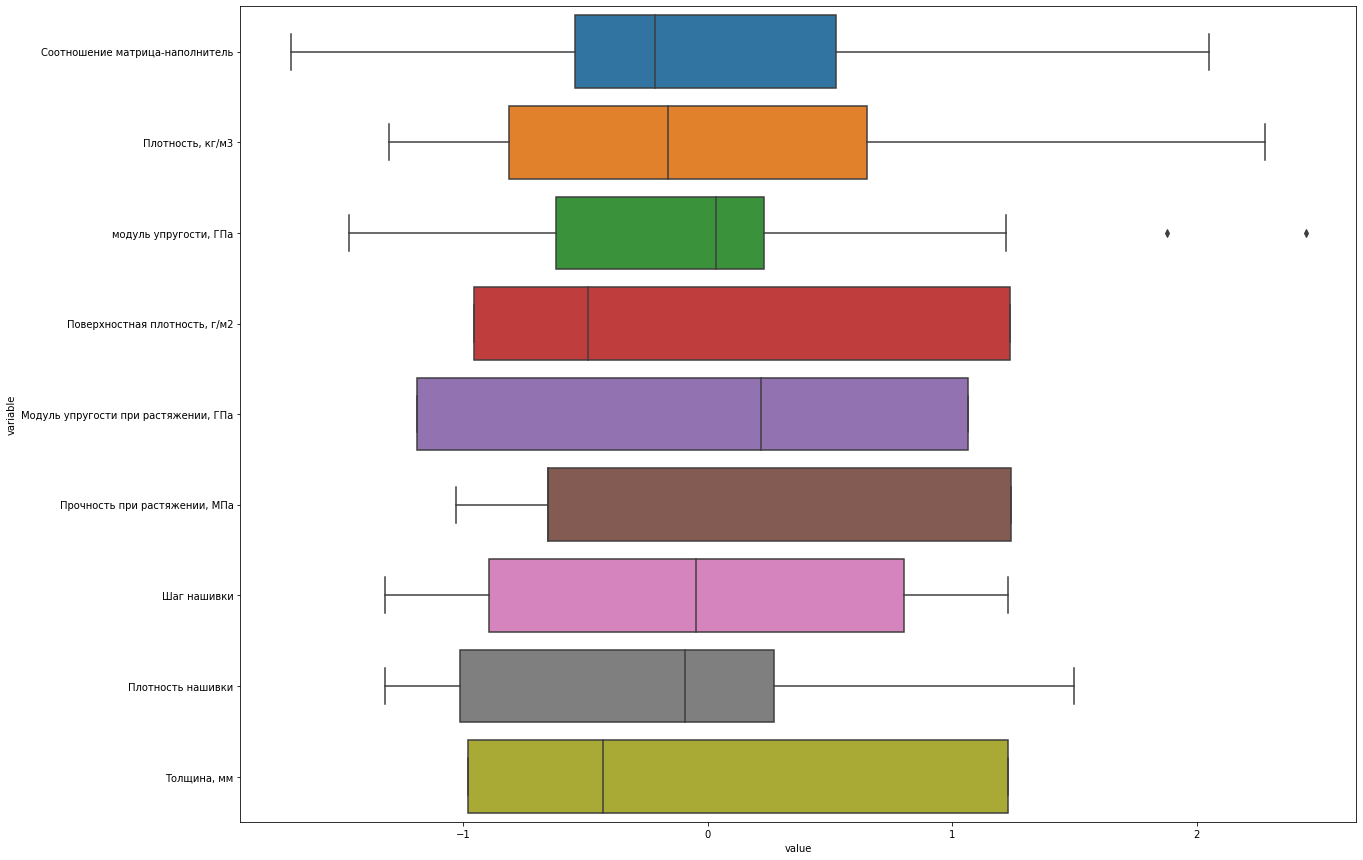

In [30]:
plt.figure(figsize=(20,15))
sns.boxplot(y="variable", x="value", data=pd.melt(df_stn))
plt.show()

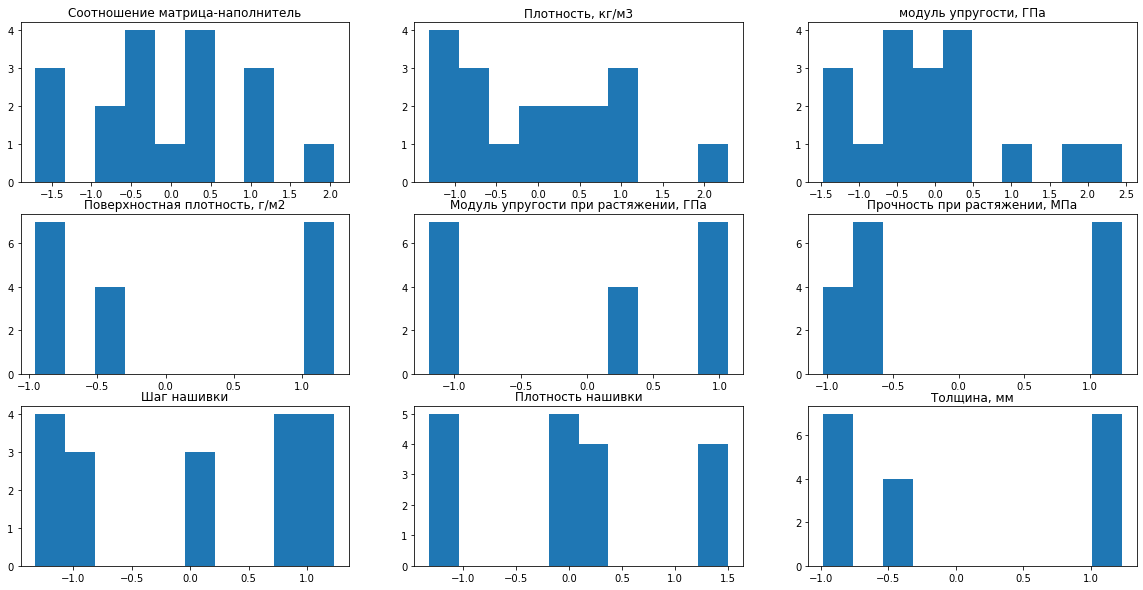

In [155]:
plt.figure(figsize=(20,10))
for index, column in zip(range(1, 10), df_stn.columns):
    plt.subplot(3, 3, index)
    plt.title(column)
    plt.hist(df_stn[column])
plt.show()

In [166]:
df_min_max = df_stn.describe().T[['min', 'max']].T
df_min_max

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
min,-1.704235,-1.303501,-1.468415,-0.954562,-1.188661,-1.030495,-1.321402,-1.319392,-0.981023
max,2.048357,2.281127,2.445829,1.234242,1.063539,1.240800,1.227016,1.496218,1.226279


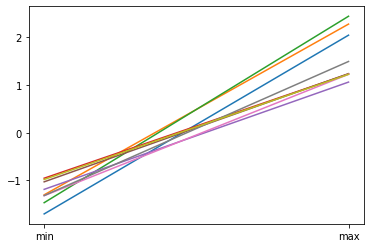

In [185]:
plt.plot(df_min_max)
plt.show()

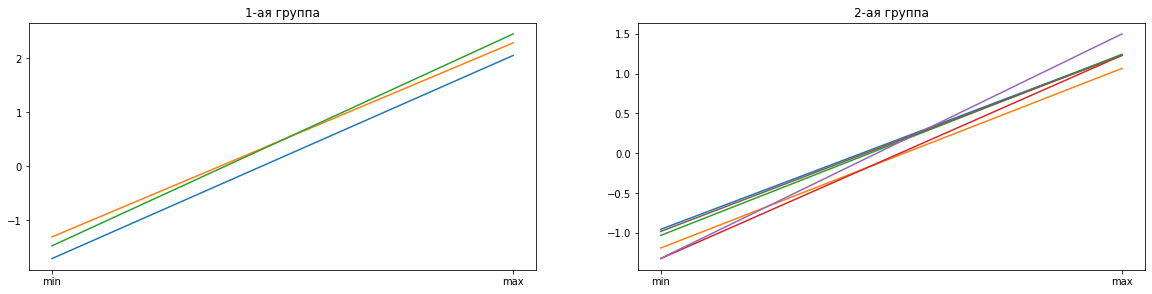

In [191]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title('1-ая группа')
plt.plot(df_min_max[['Соотношение матрица-наполнитель', 
                     'Плотность, кг/м3', 
                     'модуль упругости, ГПа']])
plt.subplot(2, 2, 2)
plt.title('2-ая группа')
plt.plot(df_min_max[['Поверхностная плотность, г/м2', 
                     'Модуль упругости при растяжении, ГПа', 
                     'Прочность при растяжении, МПа',
                     'Шаг нашивки',
                     'Плотность нашивки',
                     'Толщина, мм']])
plt.show()

## История появления метода из верхней части ноутбука

#### Тест №1.
Была попытка использования случайного леса на текущем датасете, с выделением 3х строк на тест

In [31]:
df_train = df_new.copy()

In [9]:
X = df_train.drop(columns=['Соотношение матрица-наполнитель'])
y = df_train['Соотношение матрица-наполнитель']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85)

In [234]:
regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

-1.7278181118860085

In [230]:
y_pred = regr.predict(X_test)
for i, j in zip(y_test, y_pred):
    print(i, j, abs(i-j), sep='   ')

3.53233830845771   2.8004876438728634   0.7318506645848464
2.77133105802047   2.5255628369493612   0.24576822107110896
2.93478260869565   2.755822704440551   0.1789599042550991


##### Результаты 1го теста неудовлетворительные.

#### Тест №2.
Проверяем на всей выборке

In [220]:
regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X, y)
regr.score(X, y)

0.8087896217250169

In [210]:
y_pred = regr.predict(X_test)
for i, j in zip(y_test, y_pred):
    print(i, j, abs(i-j), sep='   ')

2.56147540983606   2.561475409836056   3.9968028886505635e-15
4.02912621359223   4.029126213592234   4.440892098500626e-15
3.53233830845771   3.532338308457709   8.881784197001252e-16


##### Результаты 2го теста уже лучше, но все равно не достаточно

#### Тест №3.
Сделаем аугментацию.
Идея её в том, чтобы взять исходный датасет, добавить к нему количество датасетов равное количеству колонок, и в каждом новом датасете заполнять одну колонку порядковым счетчиком

In [32]:
X_hard = df_train.copy()
x = 1
for column in X_hard.columns:
    if column == 'Соотношение матрица-наполнитель':
        continue
    X_append = df_train.copy()
    for i in X_append[column].index:
        X_append[column][i] = x
        x += 1
    X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)

X = X_hard.drop(columns=['Соотношение матрица-наполнитель'])
y = X_hard['Соотношение матрица-наполнитель']

Для тренировки оставим только аугментированные данные, тестировать будем на оригинальных.

In [33]:
quantity_column = df_train.shape[0] 
X_train = X.iloc[quantity_column:]
y_train = y.iloc[quantity_column:]
X_test = X.iloc[:quantity_column]
y_test = y.iloc[:quantity_column]

In [37]:
X_hard.loc[12:23]

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
12,4.193548,1950.0,506.0,380.0,75.0,1800.0,9.0,60.0,0.2
13,4.897959,1890.0,540.0,380.0,75.0,1800.0,9.0,70.0,0.2
14,3.532338,1980.0,1183.0,1010.0,78.0,2000.0,10.0,47.0,0.5
15,2.877358,2000.0,205.0,1010.0,78.0,2000.0,10.0,57.0,0.5
16,1.598174,1920.0,456.0,1010.0,78.0,2000.0,10.0,60.0,0.5
17,4.029126,1880.0,622.0,1010.0,78.0,2000.0,10.0,70.0,0.5
18,1.857143,1.0,764.0,210.0,70.0,3000.0,4.0,47.0,0.1
19,2.771331,2.0,753.0,210.0,70.0,3000.0,4.0,57.0,0.1
20,2.767918,3.0,748.0,210.0,70.0,3000.0,4.0,60.0,0.1
21,2.569620,4.0,807.0,210.0,70.0,3000.0,4.0,70.0,0.1


In [413]:
X_train.head(5)

,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
18,1.0,764.0,210.0,70.0,3000.0,4.0,47.0,0.1
19,2.0,753.0,210.0,70.0,3000.0,4.0,57.0,0.1
20,3.0,748.0,210.0,70.0,3000.0,4.0,60.0,0.1
21,4.0,807.0,210.0,70.0,3000.0,4.0,70.0,0.1
22,5.0,535.0,380.0,75.0,1800.0,5.0,47.0,0.2


In [414]:
X_test.head(5)

,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
0,2030.0,764.0,210.0,70.0,3000.0,4.0,47.0,0.1
1,2030.0,753.0,210.0,70.0,3000.0,4.0,57.0,0.1
2,2000.0,748.0,210.0,70.0,3000.0,4.0,60.0,0.1
3,1910.0,807.0,210.0,70.0,3000.0,4.0,70.0,0.1
4,1900.0,535.0,380.0,75.0,1800.0,5.0,47.0,0.2


In [415]:
regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.997739167614467

In [416]:
y_pred = regr.predict(X_test)
for i, j in zip(y_test, y_pred):
    print(i, j, abs(i-j), sep='   ')

1.85714285714285   1.9002235118286128   0.04308065468576272
2.77133105802047   2.7585711106087674   0.012759947411702832
2.7679180887372   2.768589400886139   0.0006713121489387852
2.56962025316455   2.569333656794063   0.0002865963704867802
2.56147540983606   2.5844942157176343   0.023018805881574345
3.55701754385964   3.556667921358107   0.0003496225015329202
3.53233830845771   3.524048441752639   0.008289866705070814
2.87735849056603   2.876007583454935   0.0013509071110950899
1.59817351598173   1.5985719303527455   0.00039841437101539867
4.02912621359223   3.915396878925506   0.11372933466672386
2.93478260869565   2.9016950174497858   0.033087591245864356
3.55701754385964   3.550703808672873   0.006313735186767033
4.19354838709677   4.098775799527857   0.09477258756891249
4.89795918367346   4.891995052953828   0.005964130719632088
3.53233830845771   3.5275841549040603   0.004754153553649498
2.87735849056603   2.886183155156075   0.00882466459004494
1.59817351598173   1.668604811657

Результаты уже интересные. Хотя есть предположение, что модель просто выучила текущие данные.

#### Тест №4.
Сделаем такую же аугментацию, только на старте удалим из оригинального датасета 4 строки, и используем их для теста

In [514]:
X_hard = df_train.copy()
df_origin_select = X_hard.iloc[12:16]
X_hard_origin = X_hard.drop(df_origin_select.index)
X_hard = X_hard_origin.copy()
x = 1
for column in X_hard.columns:
    if column == 'Соотношение матрица-наполнитель':
        continue
    X_append = X_hard_origin.copy()
    for i in X_hard_origin[column].index:
        X_append[column][i] = random.random()
        x += 1
    X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)

X = X_hard.drop(columns=['Соотношение матрица-наполнитель'])
y = X_hard['Соотношение матрица-наполнитель']
df_origin_select

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
14,4.193548,1950.0,506.0,380.0,75.0,1800.0,9.0,60.0,0.2
15,4.897959,1890.0,540.0,380.0,75.0,1800.0,9.0,70.0,0.2
16,3.532338,1980.0,1183.0,1010.0,78.0,2000.0,10.0,47.0,0.5
17,2.877358,2000.0,205.0,1010.0,78.0,2000.0,10.0,57.0,0.5


In [515]:
X_train = X
y_train = y
X_test = df_origin_select.drop(columns=['Соотношение матрица-наполнитель'])
y_test = df_origin_select['Соотношение матрица-наполнитель']

In [518]:
regr = RandomForestRegressor(max_depth=9, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

-0.6075929275551095

In [519]:
y_pred = regr.predict(X_test)
for i, j in zip(y_test, y_pred):
    print(i, j, abs(i-j), sep='   ')

4.19354838709677   2.7026631107824794   1.4908852763142901
4.89795918367346   3.976681011976064   0.9212781716973959
3.53233830845771   3.032868116494482   0.4994701919632276
2.87735849056603   2.3177157336369105   0.5596427569291196


Результат стал хуже

#### Тест №5. Попробуем то же самое, но заменять на рандомное число

In [523]:
X_hard = df_train.copy()

for column in X_hard.columns:
    if column == 'Соотношение матрица-наполнитель':
        continue
    X_append = df_train.copy()
    for i in X_append[column].index:
        X_append[column][i] = random.random()
    X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)

X = X_hard.drop(columns=['Соотношение матрица-наполнитель'])
y = X_hard['Соотношение матрица-наполнитель']

# Разбиваем на тренировочную и тестовую выборки
quantity_column = df_train.shape[0]
X_train = X.iloc[quantity_column:]
y_train = y.iloc[quantity_column:]
X_test = X.iloc[:quantity_column]
y_test = y.iloc[:quantity_column]

In [524]:
regr = RandomForestRegressor(max_depth=9, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.999008497681888

In [525]:
y_pred = regr.predict(X_test)
for i, j in zip(y_test, y_pred):
    print(i, j, abs(i-j), sep='   ')

1.85714285714285   1.875484774752743   0.0183419176098929
2.77133105802047   2.782877376810411   0.011546318789940724
2.7679180887372   2.772330849279523   0.004412760542322758
2.56962025316455   2.5707294067042925   0.0011091535397427243
2.56147540983606   2.5648219725905506   0.003346562754490634
3.55701754385964   3.557017543859635   4.884981308350689e-15
3.53233830845771   3.532338308457709   8.881784197001252e-16
2.87735849056603   2.8898594960418915   0.012501005475861415
1.59817351598173   1.6261105280082233   0.027937012026493235
4.02912621359223   3.970206416256991   0.058919797335238666
2.93478260869565   2.9263353249875066   0.008447283708143516
3.55701754385964   3.5519553253341183   0.0050622185255218
4.19354838709677   4.135470441784976   0.05807794531179322
4.89795918367346   4.89795918367345   9.769962616701378e-15
3.53233830845771   3.525788510278792   0.006549798178917765
2.87735849056603   2.904065299474323   0.02670680890829269
1.59817351598173   1.6598709771654492 

С рандомным числом, точность выше чем в тесте с порядковым номером.

#### Тест №6.
Ради интереса попробуем ту же аугментацию с колонками, только ещё сделаем прогон и подставим рандомные значения сразу в 2 колонки

In [526]:
X_hard = df_train.copy()

#1-ый пронон, заполняем 1 колонку рандомными значениями
for column in X_hard.columns:
    if column == 'Соотношение матрица-наполнитель':
        continue
    X_append = df_train.copy()
    for i in X_append[column].index:
        X_append[column][i] = random.random()
    X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)
    
#2-ый пронон, заполняем 2 колонки рандомными значениями
count = 1
for column in range(0, 9):
    if column == 0:
        continue
    
    X_append = df_train.copy()
        
    for i in  X_append[X_append.columns[column]].index:
        X_append[X_append.columns[column]][i] = random.random()
        if column < 8:
            X_append[X_append.columns[column+1]][i] = random.random()
    
    X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)

X = X_hard.drop(columns=['Соотношение матрица-наполнитель'])
y = X_hard['Соотношение матрица-наполнитель']

# Разбиваем на тренировочную и тестовую выборки
quantity_column = df_train.shape[0]-1
X_train = X.iloc[quantity_column:]
y_train = y.iloc[quantity_column:]
X_test = X.iloc[:quantity_column]
y_test = y.iloc[:quantity_column]

In [527]:
regr = RandomForestRegressor(max_depth=9, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9999030982637824

In [528]:
y_pred = regr.predict(X_test)
for i, j in zip(y_test, y_pred):
    print(i, j, abs(i-j), sep='   ')

1.85714285714285   1.8682162839479843   0.011073426805134234
2.77133105802047   2.77478372605031   0.0034526680298396784
2.7679180887372   2.77026397649905   0.002345887761849852
2.56962025316455   2.566509101548129   0.0031111516164208375
2.56147540983606   2.5862442242345764   0.024768814398516525
3.55701754385964   3.557017543859635   4.884981308350689e-15
3.53233830845771   3.532338308457709   8.881784197001252e-16
2.87735849056603   2.8773584905660297   4.440892098500626e-16
1.59817351598173   1.5981735159817283   1.7763568394002505e-15
4.02912621359223   4.029126213592234   4.440892098500626e-15
2.93478260869565   2.9192346972711034   0.015547911424546701
3.55701754385964   3.541453163391536   0.015564380468104044
4.19354838709677   4.19354838709677   0.0
4.89795918367346   4.89795918367345   9.769962616701378e-15
3.53233830845771   3.532338308457709   8.881784197001252e-16
2.87735849056603   2.8738520842741377   0.003506406291892361
1.59817351598173   1.5981735159817283   1.7763

Вывод можно сделать сделующий:                                                            
Чем сильнее усложняется датасет для модели "Случайный лес", тем точнее она работает на текущих данных.               
Вполне возможно, что модель просто заучила ответы.

И чтобы проверить это, был создан следующий тест

#### Тест №7. 
В этом тесте будем прогонять цикл по количеству строк, на каждой итерации будет убиратся одна строка из датасета на тест, остальные строки будут аугментироваться, далее будем делать предсказание по этой строке, сравнивать с оригиналом.
В итоге посчитаем общий Score.

In [12]:
def MyTrainTestSplit(data, indexTest, targetColumn = 'Соотношение матрица-наполнитель', aug=True):
    
    X_train = data.drop(index=indexTest) 
    if aug:
        X_train = MyAugmentation(X_train, targetColumn)
    
    X_new_train = X_train.drop(columns=[targetColumn])
    y_new_train = X_train[targetColumn]
        
    X_new_test = data.loc[indexTest:indexTest].drop(columns=[targetColumn])
    y_new_test = data.loc[indexTest:indexTest][targetColumn]
    
    return X_new_train, y_new_train, X_new_test, y_new_test

In [286]:
y_list = []
for index in df_train.index:
    X_new_train, y_new_train, X_new_test, y_new_test = MyTrainTestSplit(df_train, index)
    regr = RandomForestRegressor(max_depth=7, random_state=0)
    regr.fit(X_new_train, y_new_train)
    y_pred = regr.predict(X_new_test)
    y_list.append([y_new_test.to_numpy()[0], y_pred[0]])
y_list_test_7 = y_list.copy()
y_list

[[1.85714285714285, 2.7751054483204225],
 [2.77133105802047, 2.44522389485603],
 [2.7679180887372, 2.9999717044405356],
 [2.56962025316455, 4.029126213592234],
 [2.56147540983606, 4.330449755324214],
 [3.55701754385964, 2.2528326218496715],
 [3.53233830845771, 2.7586046663620336],
 [2.87735849056603, 3.513243452886968],
 [1.59817351598173, 3.430262630934326],
 [4.02912621359223, 2.5623011680657983],
 [2.93478260869565, 3.1861190808832247],
 [3.55701754385964, 3.1152669073132184],
 [4.19354838709677, 2.6688019035612043],
 [4.89795918367346, 4.050042499916605],
 [3.53233830845771, 3.0385327767691304],
 [2.87735849056603, 2.9981647902100383],
 [1.59817351598173, 4.049619300883833],
 [4.02912621359223, 3.521913552510834]]

In [287]:
df_pred_test = pd.DataFrame(y_list, columns=['y_true', 'y_pred'])
df_pred_test['abs'] = abs(df_pred_test['y_true'] - df_pred_test['y_pred'])
df_pred_test['%'] = round(abs(df_pred_test['y_true']-df_pred_test['y_pred'])/df_pred_test['y_true'], 2)*100
r2_score(df_pred_test['y_true'], df_pred_test['y_pred'])

-0.7460476214407679

In [64]:
df_pred_test.sort_values('%')

,y_true,y_pred,abs,%
2,2.767918,2.795248,0.027330,1.0
10,2.934783,2.839751,0.095032,3.0
7,2.877358,3.059838,0.182480,6.0
17,4.029126,3.666331,0.362795,9.0
15,2.877358,2.560878,0.316481,11.0
11,3.557018,3.147614,0.409404,12.0
1,2.771331,2.392869,0.378462,14.0
13,4.897959,3.909724,0.988235,20.0
14,3.532338,2.780031,0.752308,21.0
5,3.557018,2.751528,0.805490,23.0


Можно сделать вывод из результата, либо модель на самом деле просто заучила примеры, либо эти примеры были крайне важными и исключительными, и из-за того, что они были исключены из выборки, модель не смогла обучится.

#### Тест №8. 
Попробуем через такой же алгоритм прогнать все значения всех колонок, возможно он найдёт взаимосвязи по другим колонкам.

In [13]:
def ScoreColumn(data, targetColumn, regr, aug=True):
    df_score = pd.DataFrame(columns=['y_true', 'y_pred', 'abs', '%'])
    for index in data.index:
        X_new_train, y_new_train, X_new_test, y_new_test = MyTrainTestSplit(data, index, targetColumn, aug)
        regr.fit(X_new_train, y_new_train)
        y_pred = regr.predict(X_new_test)
        y_true = y_new_test.to_numpy()[0]
        percent = round(abs(y_true-y_pred[0])/y_true, 2)*100
        pd_row = pd.DataFrame([{'y_true':y_true, 
                                'y_pred':y_pred[0], 
                                'abs':abs(y_true - y_pred[0]), 
                                '%':percent}])
        df_score = pd.concat([df_score, pd_row], ignore_index=True)
        df_score = df_score.sort_values('%')
    return r2_score(df_score['y_true'], df_score['y_pred']), df_score

In [256]:
dict_score = dict()
for column in df_train.columns:
    regr = RandomForestRegressor(max_depth=7, random_state=0)
    scoreValue, df_score = ScoreColumn(df_train, column, regr)
    dict_score[column] = {'score':scoreValue, 'df_score':df_score}

In [257]:
df_show = pd.DataFrame(columns=['score', 'value'])
list_show = []
for key in dict_score:
    list_show.append([key, dict_score.get(key).get('score')])
df_show = pd.DataFrame(list_show, columns=['score', 'value'])
print('Сводная таблица Score')
df_show.sort_values('value')

Сводная таблица Score


,score,value
2,"модуль упругости, ГПа",-0.884487
0,Соотношение матрица-наполнитель,-0.778656
7,Плотность нашивки,-0.465423
1,"Плотность, кг/м3",-0.445521
6,Шаг нашивки,0.103614
5,"Прочность при растяжении, МПа",0.984217
3,"Поверхностная плотность, г/м2",0.987581
4,"Модуль упругости при растяжении, ГПа",0.998758
8,"Толщина, мм",0.999931


Из этих результатов видно, что те колонки, где было много уникальных значений были предсказаны хуже, чем те у которых вариантов было меньше. Предполагаю что "Шаг нашивки", которое тоже плохо предсказал алгоритм, либо не правильно присоединен, либо должен использоваться как категориальная переменная.

#### Ниже выведены таблицы расхождений

In [254]:
df_show = pd.DataFrame(columns=['score', 'value'])
list_show = []
for key in dict_score:
    print('=======================================')
    print(key)
    print('---------------------------------------')
    print(dict_score.get(key).get('df_score'))

Соотношение матрица-наполнитель
---------------------------------------
      y_true    y_pred       abs      %
0   2.877358  2.871837  0.005521    0.0
1   2.934783  3.139096  0.204314    7.0
2   2.767918  3.110309  0.342391   12.0
3   2.771331  2.409216  0.362115   13.0
5   3.532338  2.992396  0.539942   15.0
17  4.029126  3.406147  0.622979   15.0
4   3.557018  3.010801  0.546217   15.0
6   4.897959  4.060578  0.837381   17.0
7   2.877358  3.513243  0.635885   22.0
8   3.532338   2.66631  0.866028   25.0
9   4.193548  2.747679   1.44587   34.0
10  4.029126  2.567615  1.461512   36.0
11  3.557018  2.244161  1.312856   37.0
12  1.857143  2.787218  0.930075   50.0
13   2.56962  4.029126  1.459506   57.0
14  2.561475  4.349721  1.788245   70.0
15  1.598174  3.421592  1.823418  114.0
16  1.598174   4.02355  2.425377  152.0
Плотность, кг/м3
---------------------------------------
    y_true       y_pred        abs    %
0   1950.0  1957.397133   7.397133  0.0
1   2030.0     2003.295     26.

Попробуем изменить глубину древьев

In [243]:
for i in range(1, 10):
    dict_score = dict()
    for column in df_train.columns:
        regr = RandomForestRegressor(max_depth=i, random_state=0)
        scoreValue, df_score = ScoreColumn(df_train, column, regr)
        dict_score[column] = {'score':scoreValue, 'df_score':df_score}
    df_show = pd.DataFrame(columns=['score', 'value'])
    list_show = []
    for key in dict_score:
        list_show.append([key, dict_score.get(key).get('score')])
    df_show = pd.DataFrame(list_show, columns=['score', 'value'])
    print('======================================')
    print('Сводная таблица Score. №' + str(i))
    print('--------------------------------------')
    print(df_show.sort_values('value'))

Сводная таблица Score. №1
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.382068
2                 модуль упругости, ГПа -0.183655
6                           Шаг нашивки  0.031009
1                      Плотность, кг/м3  0.079138
7                     Плотность нашивки  0.149122
4  Модуль упругости при растяжении, ГПа  0.873299
8                           Толщина, мм  0.939690
3         Поверхностная плотность, г/м2  0.962400
5         Прочность при растяжении, МПа  0.970268
Сводная таблица Score. №2
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.609970
2                 модуль упругости, ГПа -0.418752
7                     Плотность нашивки -0.087062
1                      Плотность, кг/м3  0.124552
6                           Шаг нашивки  0.145828
8                           Толщина, мм  0.953983
3         Поверхност

Показатель по уникальным свойствам ухудшается с увеличением уровня вложенности, а менее уникальные свойства наоборот

#### Тест №9.
Метод опорных векторов

In [42]:
y_list = []
for index in df_train.index:
    X_new_train, y_new_train, X_new_test, y_new_test = MyTrainTestSplit(df_train, index)
    clf = make_pipeline(preprocessing.StandardScaler(), svm.SVR(C=20.0, epsilon=0.001))
    clf.fit(X_new_train, y_new_train)
    y_pred = clf.predict(X_new_test)
    y_list.append([y_new_test.to_numpy()[0], y_pred[0]])

for i, j in y_list:
    print(i, j)

1.85714285714285 2.6135928855182575
2.77133105802047 2.3758581199886253
2.7679180887372 2.5505953584692467
2.56962025316455 3.7669345017076714
2.56147540983606 2.2591567766734397
3.55701754385964 3.282979152326053
3.53233830845771 2.750374112366922
2.87735849056603 4.363755060553199
1.59817351598173 3.4547679553973314
4.02912621359223 3.201986275724675
2.93478260869565 3.0730899244751293
3.55701754385964 3.698340061211481
4.19354838709677 4.057007574048189
4.89795918367346 5.2263186079078725
3.53233830845771 1.7190590750366774
2.87735849056603 2.251218377019024
1.59817351598173 2.958229823512309
4.02912621359223 1.6510208272258202


In [43]:
df_pred_test = pd.DataFrame(y_list, columns=['y_true', 'y_pred'])
df_pred_test['abs'] = abs(df_pred_test['y_true'] - df_pred_test['y_pred'])
df_pred_test['%'] = round(abs(df_pred_test['y_true']-df_pred_test['y_pred'])/df_pred_test['y_true'], 2)*100
r2_score(df_pred_test['y_true'], df_pred_test['y_pred'])

-0.4857289217870431

Попробуем постепенно увеличивать гиперпараметр "C", посмотрим  как будут менятся значения

In [44]:
for i in range(1, 20):
    dict_score = dict()
    for column in df_train.columns:
        regr = make_pipeline(preprocessing.StandardScaler(), svm.SVR(C=i, epsilon=0.001))
        scoreValue, df_score = ScoreColumn(df_train, column, regr)
        dict_score[column] = {'score':scoreValue, 'df_score':df_score}
    df_show = pd.DataFrame(columns=['score', 'value'])
    list_show = []
    for key in dict_score:
        list_show.append([key, dict_score.get(key).get('score')])
    df_show = pd.DataFrame(list_show, columns=['score', 'value'])
    print('======================================')
    print('Сводная таблица Score. №' + str(i))
    print('--------------------------------------')
    print(df_show.sort_values('value'))

Сводная таблица Score. №1
--------------------------------------
                                  score     value
5         Прочность при растяжении, МПа -0.405095
3         Поверхностная плотность, г/м2 -0.206993
7                     Плотность нашивки -0.140316
1                      Плотность, кг/м3 -0.096661
2                 модуль упругости, ГПа -0.018695
0       Соотношение матрица-наполнитель  0.036968
6                           Шаг нашивки  0.307255
8                           Толщина, мм  0.961853
4  Модуль упругости при растяжении, ГПа  0.964690
Сводная таблица Score. №2
--------------------------------------
                                  score     value
5         Прочность при растяжении, МПа -0.386184
3         Поверхностная плотность, г/м2 -0.176263
1                      Плотность, кг/м3 -0.176009
7                     Плотность нашивки -0.164551
2                 модуль упругости, ГПа -0.028968
0       Соотношение матрица-наполнитель -0.005584
6                   

Сводная таблица Score. №15
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.422955
1                      Плотность, кг/м3 -0.357148
5         Прочность при растяжении, МПа -0.203705
2                 модуль упругости, ГПа -0.117689
7                     Плотность нашивки  0.102656
3         Поверхностная плотность, г/м2  0.196544
6                           Шаг нашивки  0.398299
8                           Толщина, мм  0.953631
4  Модуль упругости при растяжении, ГПа  0.985138
Сводная таблица Score. №16
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.508533
1                      Плотность, кг/м3 -0.296095
5         Прочность при растяжении, МПа -0.171692
2                 модуль упругости, ГПа -0.112548
7                     Плотность нашивки  0.060596
3         Поверхностная плотность, г/м2  0.212621
6                 

При увеличении параметра некоторые значения поменяли знак.

In [45]:
df_show = pd.DataFrame(columns=['score', 'value'])
list_show = []
for key in dict_score:
    print('=======================================')
    print(key)
    print('---------------------------------------')
    print(dict_score.get(key).get('df_score'))

Соотношение матрица-наполнитель
---------------------------------------
      y_true    y_pred       abs      %
0   4.193548  4.105201  0.088347    2.0
1   2.934783  3.011941  0.077158    3.0
2   3.557018  3.672192  0.115175    3.0
3   4.897959     5.052  0.154041    3.0
4   3.557018  3.410768  0.146249    4.0
5   2.561475    2.3792  0.182275    7.0
6   2.767918  2.558727  0.209191    8.0
7   2.771331  2.473887  0.297444   11.0
9   3.532338  2.751408   0.78093   22.0
8   4.029126  3.133875  0.895252   22.0
10  2.877358  1.977157  0.900201   31.0
11  1.857143  2.618713   0.76157   41.0
12   2.56962  3.769752  1.200131   47.0
13  3.532338  1.715084  1.817254   51.0
14  2.877358  4.424796  1.547437   54.0
17  4.029126  1.357518  2.671608   66.0
15  1.598174  2.927509  1.329335   83.0
16  1.598174  3.489982  1.891808  118.0
Плотность, кг/м3
---------------------------------------
    y_true       y_pred         abs    %
0   1930.0  1952.244467   22.244467  1.0
1   1990.0  2016.291823   26.

#### Тест №10.
Попробуем бустинг

В качестве базового регрессора возьмем дерево решений, будем постепенно увеличивать макс вложенность

In [46]:
for i in range(1, 10):
    dict_score = dict()
    for column in df_train.columns:
        regr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=i, random_state=0),
                                 random_state=0, 
                                 n_estimators=100)
        scoreValue, df_score = ScoreColumn(df_train, column, regr)
        dict_score[column] = {'score':scoreValue, 'df_score':df_score}
    df_show = pd.DataFrame(columns=['score', 'value'])
    list_show = []
    for key in dict_score:
        list_show.append([key, dict_score.get(key).get('score')])
    df_show = pd.DataFrame(list_show, columns=['score', 'value'])
    print('======================================')
    print('Сводная таблица Score. №' + str(i))
    print('--------------------------------------')
    print(df_show.sort_values('value'))

Сводная таблица Score. №1
--------------------------------------
                                  score     value
2                 модуль упругости, ГПа -0.536124
0       Соотношение матрица-наполнитель -0.463567
6                           Шаг нашивки -0.082058
1                      Плотность, кг/м3 -0.037486
7                     Плотность нашивки  0.146456
8                           Толщина, мм  0.850733
4  Модуль упругости при растяжении, ГПа  0.858095
5         Прочность при растяжении, МПа  0.888523
3         Поверхностная плотность, г/м2  0.895213
Сводная таблица Score. №2
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.594030
2                 модуль упругости, ГПа -0.580426
7                     Плотность нашивки -0.362951
1                      Плотность, кг/м3 -0.007483
6                           Шаг нашивки  0.158901
8                           Толщина, мм  0.977580
3         Поверхност

По этим свойствам совпадения 100%, но они имеют корреляцию, тест не достоверный.
- Поверхностная плотность, г/м2 
- Модуль упругости при растяжении, ГПа
- Прочность при растяжении, МПа
- Толщина, мм

In [47]:
df_show = pd.DataFrame(columns=['score', 'value'])
list_show = []
for key in dict_score:
    print('=======================================')
    print(key)
    print('---------------------------------------')
    print(dict_score.get(key).get('df_score'))

Соотношение матрица-наполнитель
---------------------------------------
      y_true    y_pred       abs      %
0   2.771331  2.767918  0.003413    0.0
1   2.767918  2.771331  0.003413    0.0
2   2.934783  2.877358  0.057424    2.0
3   3.557018  2.934783  0.622235   17.0
4   4.897959  4.029126  0.868833   18.0
5   3.532338  2.877358   0.65498   19.0
6   3.532338  2.877358   0.65498   19.0
8   2.877358  3.532338   0.65498   23.0
7   2.877358  3.532338   0.65498   23.0
9   3.557018   2.56962  0.987397   28.0
10  4.193548  2.934783  1.258766   30.0
11  4.029126   2.56962  1.459506   36.0
12  1.857143  2.771331  0.914188   49.0
13   2.56962  4.029126  1.459506   57.0
17  4.029126  1.598174  2.430953   60.0
14  2.561475  4.193548  1.632073   64.0
15  1.598174  3.532338  1.934165  121.0
16  1.598174  4.029126  2.430953  152.0
Плотность, кг/м3
---------------------------------------
    y_true  y_pred    abs    %
0   1910.0  1910.0    0.0  0.0
1   2030.0  2000.0   30.0  1.0
2   2030.0  2000.0

Удалим часть свойств и проверим.

In [12]:
df_train_1 = df_train.copy()
df_train_1 = df_train_1.drop(columns=['Поверхностная плотность, г/м2', 'Прочность при растяжении, МПа', 'Толщина, мм'])
df_train_1.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Модуль упругости при растяжении, ГПа",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,764.0,70.0,4.0,47.0
1,2.771331,2030.0,753.0,70.0,4.0,57.0
2,2.767918,2000.0,748.0,70.0,4.0,60.0


In [14]:
# df_train_1 = df_train.copy()
for i in range(1, 15):
    dict_score = dict()
    for column in df_train_1.columns:
        regr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=i, random_state=0),
                                 random_state=0, 
                                 n_estimators=100)
        scoreValue, df_score = ScoreColumn(df_train_1, column, regr)
        dict_score[column] = {'score':scoreValue, 'df_score':df_score}
    df_show = pd.DataFrame(columns=['score', 'value'])
    list_show = []
    for key in dict_score:
        list_show.append([key, dict_score.get(key).get('score')])
    df_show = pd.DataFrame(list_show, columns=['score', 'value'])
    print('======================================')
    print('Сводная таблица Score. №' + str(i))
    print('--------------------------------------')
    print(df_show.sort_values('value'))

Сводная таблица Score. №1
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.463282
2                 модуль упругости, ГПа -0.436712
3  Модуль упругости при растяжении, ГПа -0.227786
1                      Плотность, кг/м3 -0.112928
4                           Шаг нашивки -0.014249
5                     Плотность нашивки  0.172618
Сводная таблица Score. №2
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.833713
2                 модуль упругости, ГПа -0.377579
5                     Плотность нашивки -0.150426
4                           Шаг нашивки  0.122047
1                      Плотность, кг/м3  0.211930
3  Модуль упругости при растяжении, ГПа  0.391261
Сводная таблица Score. №3
--------------------------------------
                                  score     value
0       Соотношение матрица-наполнитель -0.775621
2    

Свойство Модуль упругости при растяжении, ГПа уже не выдает таких точных результатов.

##### Попробуем изменить базовую модель на метод опорных векторов

In [15]:
for i in range(10, 15):
    dict_score = dict()
    for column in df_train.columns:
        clf = make_pipeline(preprocessing.StandardScaler(), svm.SVR(C=i, epsilon=0.001))
        regr = AdaBoostRegressor(base_estimator=clf,
                                 random_state=0, 
                                 n_estimators=5)
        scoreValue, df_score = ScoreColumn(df_train, column, regr, True)
        dict_score[column] = {'score':scoreValue, 'df_score':df_score}
    df_show = pd.DataFrame(columns=['score', 'value'])
    list_show = []
    for key in dict_score:
        list_show.append([key, dict_score.get(key).get('score')])
    df_show = pd.DataFrame(list_show, columns=['score', 'value'])
    print('======================================')
    print('Сводная таблица Score. №' + str(i))
    print('--------------------------------------')
    print(df_show.sort_values('value'))

Сводная таблица Score. №10
--------------------------------------
                                  score     value
1                      Плотность, кг/м3 -0.245221
7                     Плотность нашивки -0.145972
5         Прочность при растяжении, МПа -0.140276
2                 модуль упругости, ГПа -0.121346
3         Поверхностная плотность, г/м2 -0.049261
0       Соотношение матрица-наполнитель -0.016172
6                           Шаг нашивки  0.332214
8                           Толщина, мм  0.952829
4  Модуль упругости при растяжении, ГПа  0.958941
Сводная таблица Score. №11
--------------------------------------
                                  score     value
1                      Плотность, кг/м3 -0.184219
5         Прочность при растяжении, МПа -0.123426
2                 модуль упругости, ГПа -0.079889
0       Соотношение матрица-наполнитель -0.078360
7                     Плотность нашивки -0.073366
3         Поверхностная плотность, г/м2  0.107809
6                 

In [16]:
df_show = pd.DataFrame(columns=['score', 'value'])
list_show = []
for key in dict_score:
    print('=======================================')
    print(key)
    print('---------------------------------------')
    print(dict_score.get(key).get('df_score'))

Соотношение матрица-наполнитель
---------------------------------------
      y_true    y_pred       abs     %
0   4.193548  4.148415  0.045133   1.0
1   2.877358  2.815578   0.06178   2.0
2   4.897959  5.243381  0.345422   7.0
3   3.557018  3.281266  0.275751   8.0
4   3.557018  3.275757  0.281261   8.0
5   2.561475  2.823415  0.261939  10.0
6   2.934783  3.217301  0.282519  10.0
7   2.767918  2.414758   0.35316  13.0
8   4.029126  3.463523  0.565603  14.0
9   3.532338  2.909896  0.622442  18.0
10  2.771331  2.244906  0.526425  19.0
11  1.857143  2.541351  0.684208  37.0
12  3.532338  2.240495  1.291844  37.0
13   2.56962  3.681632  1.112012  43.0
14  2.877358  4.272692  1.395334  48.0
17  4.029126  1.695098  2.334029  58.0
15  1.598174  2.644107  1.045933  65.0
16  1.598174  2.787637  1.189464  74.0
Плотность, кг/м3
---------------------------------------
    y_true       y_pred         abs    %
0   1990.0  1997.341653    7.341653  0.0
1   1930.0  1954.486748   24.486748  1.0
2   195

Результаты так себе.

## Попробуем нейронную сеть

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 10])
    plt.xlabel('Эпоха')
    plt.ylabel('MAE [MPG]')
    plt.legend()
    plt.grid(True)

##### Подготовим сетку для обучения нейросети

In [15]:
#Возможные функции оценки ошибки
list_loss = ['mean_squared_error', 
             'mean_absolute_error', 
             'mean_absolute_percentage_error',  
             'mean_squared_logarithmic_error']

#Возможные оптимизаторы
list_optimizer = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']

#Возможное количество эпох
list_epoch = [30, 40, 50, 60]

#Возможное количество скрытых слоев
list_dense = [3, 4, 5, 6]

#Возможное количество нейронов на слое
list_neuron = [64, 128]

#Общий список
pd_loss = pd.DataFrame(list_loss, columns=['loss'])
pd_loss['key'] = 1
pd_optimizer = pd.DataFrame(list_optimizer, columns=['optimizer'])
pd_optimizer['key'] = 1
pd_epoch = pd.DataFrame(list_epoch, columns=['epoch'])
pd_epoch['key'] = 1
pd_dense = pd.DataFrame(list_dense, columns=['dense'])
pd_dense['key'] = 1
pd_neuron = pd.DataFrame(list_neuron, columns=['neuron'])
pd_neuron['key'] = 1
pd_param = pd.merge(pd_loss, pd_optimizer, on ='key')
pd_param = pd.merge(pd_param, pd_epoch, on ='key')
pd_param = pd.merge(pd_param, pd_dense, on ='key')
pd_param = pd.merge(pd_param, pd_neuron, on ='key')
pd_param['score'] = 0


#Слишком много параметров получается, оставлю для истории

# pd_denses = pd.DataFrame(list_dense, columns=['dense'])
# pd_denses['key1'] = 1
# pd_denses['key2'] = 1
# pd_denses['key3'] = 1
# pd_denses['key4'] = 0
# pd_denses['key5'] = 0
# pd_denses['key6'] = 0
# pd_denses['key7'] = 0

# pd_denses['key2'][pd_denses['dense']>1] = 1
# pd_denses['key3'][pd_denses['dense']>2] = 1
# pd_denses['key4'][pd_denses['dense']>3] = 1
# pd_denses['key5'][pd_denses['dense']>4] = 1
# pd_denses['key6'][pd_denses['dense']>5] = 1
# pd_denses['key7'][pd_denses['dense']>6] = 1

# for i in range(1, len(list_dense)+1):
#     key = 'key' + str(i)
#     pd_neuron = pd.DataFrame(list_neuron, columns=['neuron' + str(i)])
#     pd_neuron[key] = 1
#     pd_denses = pd.merge(pd_denses, pd_neuron, left_on=key, right_on=key, how='outer')
# for i in range(1, max(list_dense)+1):
#     pd_denses = pd_denses.drop(columns=['key' + str(i)])

pd_param

,loss,key,optimizer,epoch,dense,neuron,score
0,mean_squared_error,1,SGD,30,3,64,0
1,mean_squared_error,1,SGD,30,3,128,0
2,mean_squared_error,1,SGD,30,4,64,0
3,mean_squared_error,1,SGD,30,4,128,0
4,mean_squared_error,1,SGD,30,5,64,0
...,...,...,...,...,...,...,...
891,mean_squared_logarithmic_error,1,Nadam,60,4,128,0
892,mean_squared_logarithmic_error,1,Nadam,60,5,64,0
893,mean_squared_logarithmic_error,1,Nadam,60,5,128,0
894,mean_squared_logarithmic_error,1,Nadam,60,6,64,0


In [20]:
def get_dense(param):
    list_dense = []
    for i in range(1, int(param['dense']) + 1):
        list_dense.append(layers.Dense(int(param['neuron']), activation='relu'))
    return list_dense

In [21]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(df_train.drop(columns=['Соотношение матрица-наполнитель'])))

In [22]:
def build_and_compile_model(loss, optimizer, dense):
    
    model = keras.Sequential([normalizer])
    for dense_param in dense:
        model.add(dense_param)
    model.add(layers.Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [18]:
def fit_model(df_train, index, y_list, loss, optimizer, dense, epoch):
    X_new_train, y_new_train, X_new_test, y_new_test = MyTrainTestSplit(df_train, index, aug=False)
    dnn_model = build_and_compile_model(loss, optimizer, dense)
    dnn_model.fit(
        X_new_train,
        y_new_train,
        validation_data=(X_new_test, y_new_test),
        verbose=0, epochs=epoch)
    y_pred = dnn_model.predict(X_new_test)
    y_list.append([y_new_test.to_numpy()[0], y_pred[0][0]])
    return dnn_model

In [17]:
def score_model(df_train, label, loss, optimizer, dense, epoch):
    y_list = []
    for index in tqdm(df_train.index, desc=label):
        dnn_model = fit_model(df_train, index, y_list, loss, optimizer, dense, epoch)
    df_pred_test = pd.DataFrame(y_list, columns=['y_true', 'y_pred'])
    score = r2_score(df_pred_test['y_true'], df_pred_test['y_pred'])
    return score, dnn_model, df_pred_test

In [30]:
for i in pd_param.index:
    try:
        row = pd_param[i:i+1]
        dense = get_dense(row)
        score = score_model(df_train, str(i), row['loss'][i], row['optimizer'][i], dense, row['epoch'][i])
        pd_param['score'][i] = score
        pd_param.to_csv('pd_param.csv', index=False)
    except:
        pass

135: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:19<00:00,  1.09s/it]


271: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:29<00:00,  1.65s/it]


407: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:27<00:00,  1.54s/it]


543: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:34<00:00,  1.90s/it]


679: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:23<00:00,  1.30s/it]


815: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:27<00:00,  1.50s/it]


895: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [01:13<00:00,  4.11s/it]


#### Кроссвалидация продлилась около 7ч. Далее результаты.

In [16]:
pd_param_copy = pd_param.copy()
pd_param_copy = pd_param_copy.sort_values(by='score')

##### Топ 20 худших параметров

In [137]:
pd_param_copy.head(20)

,loss,key,optimizer,epoch,dense,neuron,score
894,mean_squared_logarithmic_error,1,Nadam,60,6,64,-34.108542
838,mean_squared_logarithmic_error,1,Adamax,30,6,64,-28.470162
870,mean_squared_logarithmic_error,1,Nadam,30,6,64,-26.614745
863,mean_squared_logarithmic_error,1,Adamax,60,6,128,-25.826467
758,mean_squared_logarithmic_error,1,Adam,50,6,64,-24.835470
734,mean_squared_logarithmic_error,1,RMSprop,60,6,64,-24.526641
738,mean_squared_logarithmic_error,1,Adam,30,4,64,-22.169379
891,mean_squared_logarithmic_error,1,Nadam,60,4,128,-21.234684
871,mean_squared_logarithmic_error,1,Nadam,30,6,128,-21.087876
718,mean_squared_logarithmic_error,1,RMSprop,40,6,64,-20.876546


##### Топ 20 лучших параметров

In [138]:
pd_param_copy.tail(20)

,loss,key,optimizer,epoch,dense,neuron,score
319,mean_absolute_error,1,Adam,60,6,128,0.888209
221,mean_squared_error,1,Nadam,60,5,128,0.889966
30,mean_squared_error,1,SGD,60,6,64,0.890942
28,mean_squared_error,1,SGD,60,5,64,0.892412
205,mean_squared_error,1,Nadam,40,5,128,0.896600
22,mean_squared_error,1,SGD,50,6,64,0.897999
535,mean_absolute_percentage_error,1,Adam,50,6,128,0.898335
311,mean_absolute_error,1,Adam,50,6,128,0.902163
639,mean_absolute_percentage_error,1,Adamax,60,6,128,0.902677
541,mean_absolute_percentage_error,1,Adam,60,5,128,0.903033


In [140]:
pd_param_copy[pd_param_copy['score']>0.8]

,loss,key,optimizer,epoch,dense,neuron,score
621,mean_absolute_percentage_error,1,Adamax,40,5,128,0.800147
635,mean_absolute_percentage_error,1,Adamax,60,4,128,0.801344
26,mean_squared_error,1,SGD,60,4,64,0.802854
444,mean_absolute_error,1,Nadam,60,5,64,0.803017
308,mean_absolute_error,1,Adam,50,5,64,0.803125
...,...,...,...,...,...,...,...
309,mean_absolute_error,1,Adam,50,5,128,0.930447
413,mean_absolute_error,1,Adamax,60,5,128,0.932957
212,mean_squared_error,1,Nadam,50,5,64,0.940609
317,mean_absolute_error,1,Adam,60,5,128,0.947384


##### Сводная статистика по лучшим параметрам

In [238]:
pd_param_80 = pd_param_copy[pd_param_copy['score']>0.8]
print('Лучшие Loss функции:')
pd_param_80.pivot_table(values=['key'], index=['loss'], aggfunc='sum').sort_values(by='key')

Лучшие Loss функции:


,key
loss,
mean_absolute_percentage_error,31
mean_absolute_error,33
mean_squared_error,39


In [237]:
print('Лучшие Optimizer функции')
pd_param_80.pivot_table(values=['key'], index=['optimizer'], aggfunc='sum').sort_values(by='key')

Лучшие Optimizer функции


,key
optimizer,
RMSprop,12
Adamax,16
SGD,16
Adam,25
Nadam,34


In [239]:
print('Лучшие количество epoch')
pd_param_80.pivot_table(values=['key'], index=['epoch'], aggfunc='sum').sort_values(by='key')

Лучшие количество epoch


,key
epoch,
30,6
40,21
50,32
60,44


In [240]:
print('Лучшие количество слоев')
pd_param_80.pivot_table(values=['key'], index=['dense'], aggfunc='sum').sort_values(by='key')

Лучшие количество слоев


,key
dense,
3,2
4,27
5,33
6,41


In [241]:
print('Лучшие количество нейронов')
pd_param_80.pivot_table(values=['key'], index=['neuron'], aggfunc='sum').sort_values(by='key')

Лучшие количество нейронов


,key
neuron,
64,37
128,66


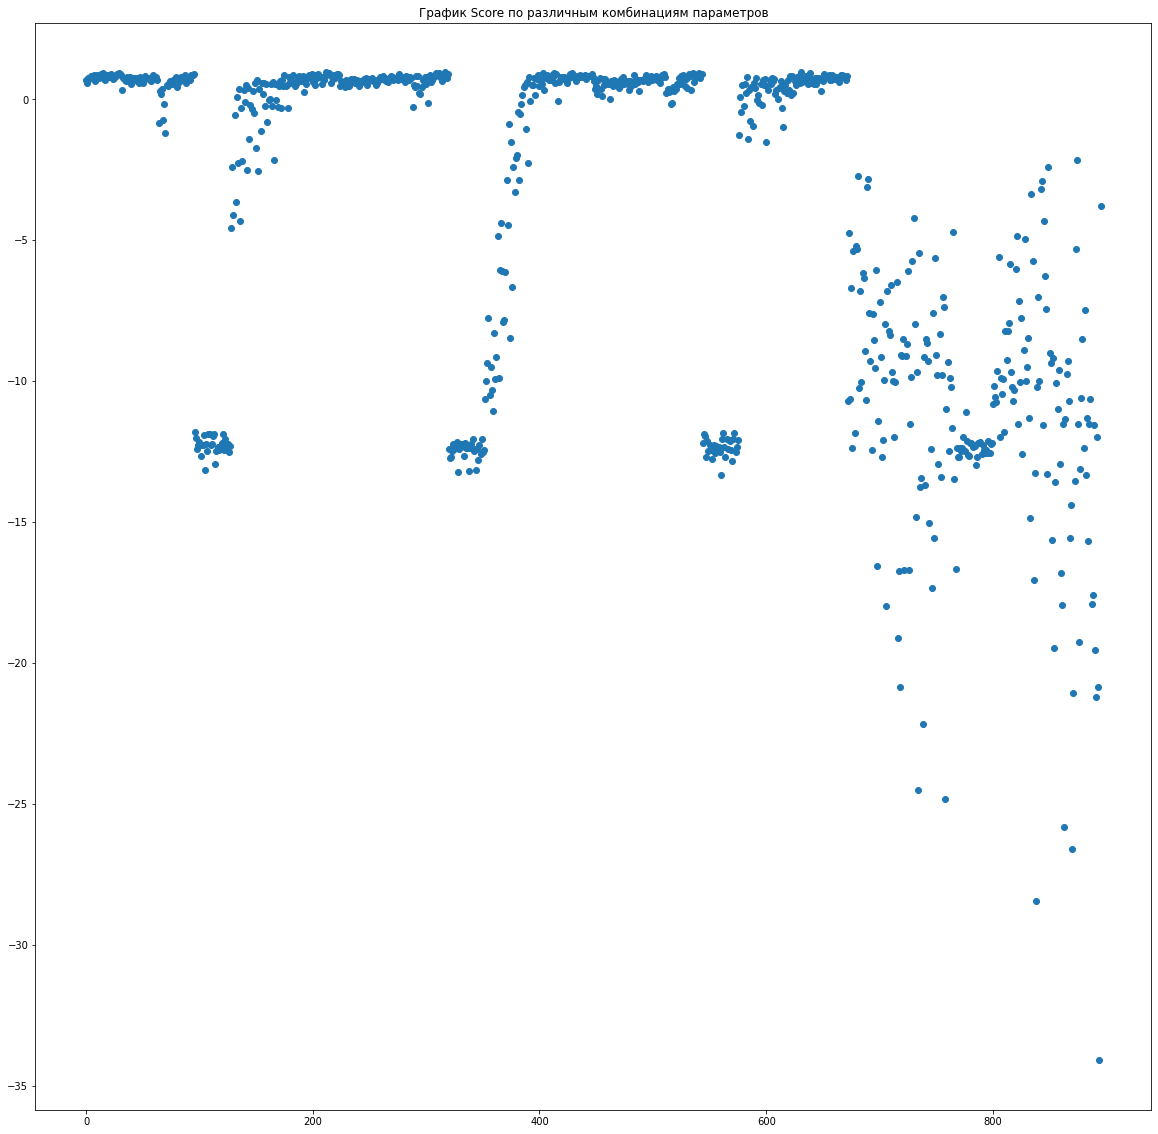

In [233]:
plt.figure(figsize=(20,20))
plt.title('График Score по различным комбинациям параметров')
plt.scatter(pd_param.index, pd_param['score'])

##### Попробуем ещё раз получить Score, по 2м лучшим моделям

In [145]:
index_row = 631
row = pd_param[index_row:index_row+1]
row
dense = get_dense(row)
score, model_best, df_best = score_model(df_train, 'Best of the best', 
                    row['loss'][index_row], 
                    row['optimizer'][index_row], 
                    dense, 
                    row['epoch'][index_row])
score

Best of the best: 100%|████████████████████████████████████████████████████████████████| 18/18 [00:48<00:00,  2.70s/it]


0.8618329777506573

In [146]:
df_best

,y_true,y_pred
0,1.857143,2.904504
1,2.771331,2.506175
2,2.767918,2.539871
3,2.569620,2.973615
4,2.561475,2.564919
5,3.557018,3.326811
6,3.532338,3.649549
7,2.877358,3.029385
8,1.598174,1.501027
9,4.029126,3.975831


In [147]:
index_row = 317
row = pd_param[index_row:index_row+1]
row
dense = get_dense(row)
score_2, model_best_2, df_best_2 = score_model(df_train, 'Best of the best', 
                    row['loss'][index_row], 
                    row['optimizer'][index_row], 
                    dense, 
                    row['epoch'][index_row])
score_2

Best of the best: 100%|████████████████████████████████████████████████████████████████| 18/18 [00:46<00:00,  2.57s/it]


0.9422102876592096

In [148]:
df_best_2

,y_true,y_pred
0,1.857143,2.483029
1,2.771331,2.843642
2,2.767918,2.784822
3,2.569620,2.895762
4,2.561475,2.549928
5,3.557018,3.310841
6,3.532338,3.421998
7,2.877358,3.024019
8,1.598174,1.571045
9,4.029126,3.872411


##### Вторая модель оказалась точнее. Её и возьмём 

In [23]:
index_row = 317
row = pd_param[index_row:index_row+1]
row
dense = get_dense(row)
epoch = row['epoch'][index_row]
model_best_2 = build_and_compile_model(row['loss'][index_row], row['optimizer'][index_row], dense)
model_best_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                        

##### Сделаем тест на всей выборке 

In [24]:
X_train_best = df_train.drop(columns=['Соотношение матрица-наполнитель'])
y_train_best = df_train['Соотношение матрица-наполнитель']

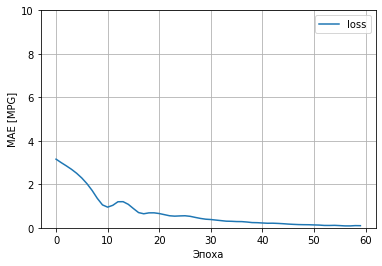

In [25]:
history = model_best_2.fit(
        X_train_best,
        y_train_best,
        verbose=0, epochs=epoch)
plot_loss(history)

In [26]:
y_pred = model_best_2.predict(df_train.drop(columns=['Соотношение матрица-наполнитель']))
for i, j in zip(y_train_best, y_pred):
    print(i, j[0], sep='    ')

1.85714285714285    1.8192295
2.77133105802047    2.7682023
2.7679180887372    2.7284768
2.56962025316455    2.826855
2.56147540983606    2.6516926
3.55701754385964    3.625281
3.53233830845771    3.6111398
2.87735849056603    2.8755445
1.59817351598173    1.5811204
4.02912621359223    4.013665
2.93478260869565    2.9808097
3.55701754385964    3.5319715
4.19354838709677    4.285207
4.89795918367346    4.91086
3.53233830845771    3.5922077
2.87735849056603    2.9291897
1.59817351598173    2.1510308
4.02912621359223    3.9405692


In [27]:
model_best_2.evaluate(X_train_best, y_train_best)

1/1 [==============================] - 0s 120ms/step - loss: 0.0854


0.08544859290122986

Результаты хорошие. Главное чтобы на всей выборке модель не заучила ответы. 

In [31]:
#Сохраним модель
model_best_2.save('model_NN_best') 

INFO:tensorflow:Assets written to: model_NN_best\assets


##### Предскажем свойства с Nan 

In [29]:
df_nan = df[np.isnan(df['Соотношение матрица-наполнитель'])]
df_nan

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа",Шаг нашивки,Плотность нашивки,"Толщина, мм"
7,NaN,2160.0,933.0,1010.0,78.0,2000.0,5.0,70.0,0.5
10,NaN,1980.0,568.0,210.0,70.0,3000.0,7.0,60.0,0.1


In [207]:
model_best_2.predict(df_nan.drop(columns=['Соотношение матрица-наполнитель']))

array([[4.614114 ],
       [2.8119125]], dtype=float32)

##### Сравним с моделью случайного леса

In [244]:
X_hard = df_train.copy()

for column in X_hard.columns:
    if column == 'Соотношение матрица-наполнитель':
        continue
    X_append = df_train.copy()
    for i in X_append[column].index:
        X_append[column][i] = random.random()
    X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)

X = X_hard.drop(columns=['Соотношение матрица-наполнитель'])
y = X_hard['Соотношение матрица-наполнитель']

# Разбиваем на тренировочную и тестовую выборки
quantity_column = df_train.shape[0]
X_train = X.iloc[quantity_column:]
y_train = y.iloc[quantity_column:]
X_test = X.iloc[:quantity_column]
y_test = y.iloc[:quantity_column]
regr = RandomForestRegressor(max_depth=9, random_state=0)
regr.fit(X_train, y_train)
regr.predict(df_nan.drop(columns=['Соотношение матрица-наполнитель']))

array([2.90399611, 3.16342583])

Результаты второго значения оказались близки друг к другу. Первый же наоборот.

### Используем предыдущую модель нейронной сети для прогноза "Модуль упругости при растяжении, ГПа" и "Прочность при растяжении, МПа" случайный лес

Возьмем те же параметры для модели, что и для предыдущего расчета

In [265]:
X_train_3 = df_train.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'])
y_train_3 = df_train[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]

In [266]:
normalizer1 = tf.keras.layers.Normalization(axis=-1)
normalizer1.adapt(np.array(X_train_3))

In [339]:
def build_and_compile_model1(loss, optimizer, dense):
    
    model = keras.Sequential([normalizer1])
    for dense_param in dense:
        model.add(dense_param)
    model.add(layers.Dense(2))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [348]:
index_row = 317
row = pd_param[index_row:index_row+1]
row
dense = get_dense(row)
epoch = row['epoch'][index_row]
model_best_2 = build_and_compile_model1(row['loss'][index_row], row['optimizer'][index_row], dense)
model_best_2.summary()

Model: "sequential_16395"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 7)                15        
 ion)                                                            
                                                                 
 dense_20703 (Dense)         (None, 128)               1024      
                                                                 
 dense_20704 (Dense)         (None, 128)               16512     
                                                                 
 dense_20705 (Dense)         (None, 128)               16512     
                                                                 
 dense_20706 (Dense)         (None, 128)               16512     
                                                                 
 dense_20707 (Dense)         (None, 128)               16512     
                                                  

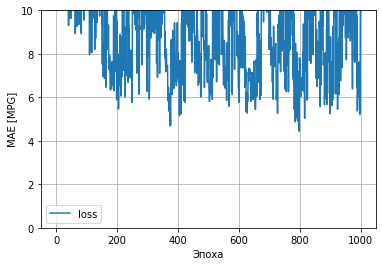

In [354]:
history = model_best_2.fit(
        X_train_3,
        y_train_3,
        verbose=0, epochs=1000)
plot_loss(history)

In [355]:
model_best_2.evaluate(X_train_3, y_train_3)

1/1 [==============================] - 0s 22ms/step - loss: 6.6241


6.624134540557861

In [356]:
model_best_2.predict(X_train_3)

array([[  70.440895, 2984.3528  ],
       [  70.06668 , 2987.6807  ],
       [  70.36897 , 2987.5095  ],
       [  70.17775 , 2989.328   ],
       [  49.888626, 1792.3735  ],
       [  50.99315 , 1791.4954  ],
       [  77.71712 , 1997.8639  ],
       [  79.17441 , 1996.4011  ],
       [  77.285645, 1995.2681  ],
       [  78.6104  , 2988.6582  ],
       [  71.7491  , 2991.6223  ],
       [  79.15395 , 2987.5996  ],
       [  55.823036, 1794.4893  ],
       [  62.257713, 1798.0217  ],
       [  80.62009 , 2001.3605  ],
       [  78.81861 , 1998.4448  ],
       [  78.668106, 1997.4514  ],
       [  79.5024  , 1993.7175  ]], dtype=float32)

##### Задумка себя не оправдала. Попадений мало.

### Попробуем модель случайного леса

#### Пробуем сразу с аугментацией

In [277]:
y_train_3

,"Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа"
0,70.0,3000.0
1,70.0,3000.0
2,70.0,3000.0
3,70.0,3000.0
4,75.0,1800.0
5,75.0,1800.0
6,78.0,2000.0
8,78.0,2000.0
9,78.0,2000.0
11,70.0,3000.0


In [366]:
X_hard = df_train.copy()

for column in X_hard.columns:
    if column == 'Модуль упругости при растяжении, ГПа' or column == 'Прочность при растяжении, МПа':
        continue
    X_append = df_train.copy()
    for i in X_append[column].index:
        X_append[column][i] = random.random()
    X_hard = pd.concat([X_hard, X_append], axis=0, ignore_index=True)

X = X_hard.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'])
y = X_hard[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]

# Разбиваем на тренировочную и тестовую выборки
quantity_column = df_train.shape[0]
X_train = X.iloc[quantity_column:]
y_train = y.iloc[quantity_column:]
X_test = X.iloc[:quantity_column]
y_test = y.iloc[:quantity_column]
regr_mp = RandomForestRegressor(max_depth=9, random_state=0)
regr_mp.fit(X_train, y_train)
regr_mp.score(X_test, y_test)

0.9999759586314698

In [367]:
regr_mp.predict(X_test)

array([[  70.  , 3000.  ],
       [  70.  , 3000.  ],
       [  70.  , 3000.  ],
       [  70.  , 3000.  ],
       [  75.  , 1800.  ],
       [  75.  , 1800.  ],
       [  77.92, 2010.  ],
       [  78.  , 2000.  ],
       [  78.  , 2000.  ],
       [  70.  , 3000.  ],
       [  70.  , 3000.  ],
       [  70.  , 3000.  ],
       [  75.  , 1800.  ],
       [  75.  , 1800.  ],
       [  78.  , 2000.  ],
       [  78.  , 2000.  ],
       [  78.  , 2000.  ],
       [  78.  , 2000.  ]])

Результат отличный. Может модель выучила ответы.

#### Проверим на чистой выборке с выделением тестовой части 3 строки

In [391]:
X = df_train.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'])
y = df_train[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85)
regr_mp = RandomForestRegressor(max_depth=9, random_state=0)
regr_mp.fit(X_train, y_train)
regr_mp.score(X_test, y_test)

0.9859599166666666

In [392]:
y_pred = regr_mp.predict(X_test)
for i, j in zip(y_test.to_numpy(), y_pred):
    print(i[0], i[1], j[0], j[1], sep='   ')

70.0   3000.0   70.0   3000.0
70.0   3000.0   70.0   3000.0
75.0   1800.0   75.64   1858.0


##### Результат шикарный!

#### Попробуем увеличить тестовую выборку

In [393]:
X = df_train.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'])
y = df_train[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.70)
regr_mp = RandomForestRegressor(max_depth=9, random_state=0)
regr_mp.fit(X_train, y_train)
regr_mp.score(X_test, y_test)

0.9405764218749999

In [394]:
y_pred = regr_mp.predict(X_test)
for i, j in zip(y_test.to_numpy(), y_pred):
    print(i[0], i[1], j[0], j[1], sep='   ')

70.0   3000.0   70.33   2930.0
78.0   2000.0   77.09   2062.0
70.0   3000.0   71.06   2764.0
70.0   3000.0   70.76   2836.0
70.0   3000.0   70.48   2894.0
78.0   2000.0   77.32   2062.0


Результат похуже, но всё равно гораздо лучше чем у нейронной сети.

#### Ещё увеличим тестовую выборку

In [395]:
X = df_train.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'])
y = df_train[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.60)
regr_mp = RandomForestRegressor(max_depth=9, random_state=0)
regr_mp.fit(X_train, y_train)
regr_mp.score(X_test, y_test)

0.9808574358974359

In [396]:
y_pred = regr_mp.predict(X_test)
for i, j in zip(y_test.to_numpy(), y_pred):
    print(i[0], i[1], j[0], j[1], sep='   ')

78.0   2000.0   77.18   1976.0
70.0   3000.0   70.1   2976.0
75.0   1800.0   75.24   1954.0
70.0   3000.0   70.28   2942.0
78.0   2000.0   77.24   1980.0
70.0   3000.0   70.1   2976.0
78.0   2000.0   77.82   1988.0
75.0   1800.0   75.18   1950.0


##### Результат всё ещё удовлетворительный

#### Есть предположение, что вся эта идилия рушится дропом корреляционных колонок

In [22]:
X = df_train.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа', 'Поверхностная плотность, г/м2', 'Толщина, мм'])
y = df_train[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.90)
regr_mp = RandomForestRegressor(max_depth=9, random_state=0)
regr_mp.fit(X_train, y_train)
regr_mp.score(X_test, y_test)

-6.9956111111111134

In [23]:
y_pred = regr_mp.predict(X_test)
for i, j in zip(y_test.to_numpy(), y_pred):
    print(i[0], i[1], j[0], j[1], sep='   ')

78.0   2000.0   75.74   2202.0
75.0   1800.0   74.28   2304.0


##### Так и есть, если несколько раз прогнать, иногда чудесным образом, более-менее угадывает

Но у нас есть эти корреляционные свойства, и будем считать, что задача решена!

In [42]:
#Итоговая модель для сохранения
X = df_train.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'])
y = df_train[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]
regr_mp_last = RandomForestRegressor(max_depth=9, random_state=0)
regr_mp_last.fit(X, y)
regr_mp_last.score(X, y)

0.9991853505389178

In [50]:
#Сохраним модель
dump(regr_mp_last, 'RandomForestRegressor.joblib') 

['RandomForestRegressor.joblib']

In [64]:
mmm=load_model('C:\python\GitRepositories\django_task_list\predictBP\model_NN_best')
mmm